# Analyis of ERPs

## Optiones

In [5]:
bids_root_path= "/home/marc/galaxy/xmasoddballmatch-bids"
pipeline_name = "pipeline01_noautoreject"
bids_root_path = "/home/marc/galaxy/machristine-bids"
pipeline_name = "pipeline_christine"

bids_root_path= "/media/marc/Medien/xmasoddballmatch-bids"
pipeline_name = "pipeline01"

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

## Loading Dependencies and Defining Functions
Load MNE and read configuration file.

In [6]:
from ...configuration.configuration import load_configuration

import utils

from os.path import join
import mne
from mne_bids import make_bids_basename, read_raw_bids
from mne_bids.utils import get_entity_vals

import plotting

import seaborn as sns

config = load_configuration()


In [7]:
def difference_wave(evokeds_as_dict, conditions, grandaverage=False):
    out = [mne.combine_evoked([a, b], [1,-1]) for a, b in zip(
        evokeds_as_dict[conditions[0]], evokeds_as_dict[conditions[1]])]
    if grandaverage:
        return mne.grand_average(out)
    else:
        return out

## Read averaged ERPs from disk

Read averaged ERPs for each participant:

In [18]:
#%%capture
ids = get_entity_vals(join(bids_root_path, "derivatives"), "sub") 
ave_filenames = [utils.get_derivative_file_name(
        bids_root_path, id, pipeline_name, ".fif", suffix="ave") for id in ids]
all_evokeds = [mne.read_evokeds(ave_filename) for ave_filename in ave_filenames]

Turn list of dicts of ERPs into dict of lists of ERPs:

In [5]:
evokeds_list_as_dict = {key: [] for key in config["conditions_of_interest"]}

for evokeds_list in all_evokeds:
    for evoked in evokeds_list:
        try:
            evokeds_list_as_dict[evoked.comment].append(evoked)
        except KeyError:
            pass
            print("Missing condition in list.")

## Find Preak Latency and Window
Following Sussmann (2005), peak laency is defined as the latency where the differnce wave between deviant and standard tones in the random condition reaches its maximum (within the `Fz` channel).

In [6]:
# Find peak and find a window (±25ms) 
diff = difference_wave(evokeds_list_as_dict, ("random/deviant", "random/standard"), grandaverage=True)
peak_latency = diff.pick(picks="FZ").get_peak(tmin = .1, tmax = .2,  return_amplitude = True)[1]

peakwindow = (peak_latency-0.025, peak_latency+0.025)

print("Peak Latency is {} s.".format(peak_latency))

Identifying common channels ...
Peak Latency is 0.134765625 s.


## Difference Waves (nopattern)

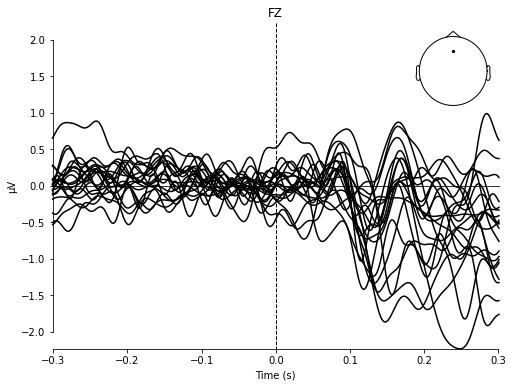

[<Figure size 576x432 with 2 Axes>]

In [7]:
diff_waves = {str(n):mne.combine_evoked([eb, ea], weights=[1, -1]) for ea, eb, n in zip(evokeds_list_as_dict["random/nopattern/standard"], evokeds_list_as_dict["random/nopattern/deviant"], range(20))}
mne.viz.plot_compare_evokeds(diff_waves, picks="FZ", ci=False, colors=["black"]*25, legend=False)

## Visualize different Standards
Standards differ depending on their position in repsect to the preceeding deviant. Let's compare standards in the `random` condition:

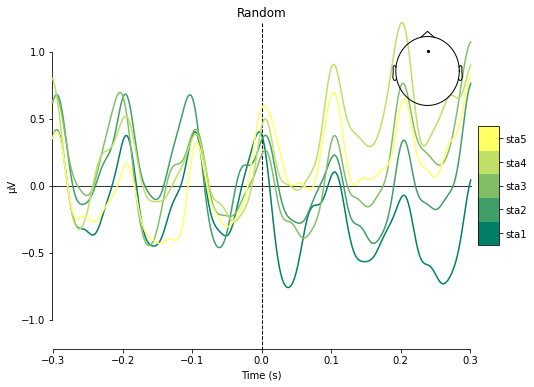

[<Figure size 576x432 with 3 Axes>]

In [8]:
mne.viz.plot_compare_evokeds(   {"sta1":evokeds_list_as_dict["random/1/standard"],
                                 "sta2":evokeds_list_as_dict["random/2/standard"],
                                 "sta3":evokeds_list_as_dict["random/3/standard"],
                                 "sta4":evokeds_list_as_dict["random/4/standard"],
                                 "sta5":evokeds_list_as_dict["random/5/standard"]}, picks="FZ", ci=False, cmap="summer", title="Random")

Now we do the same for standardars in the `predicatble` condition:

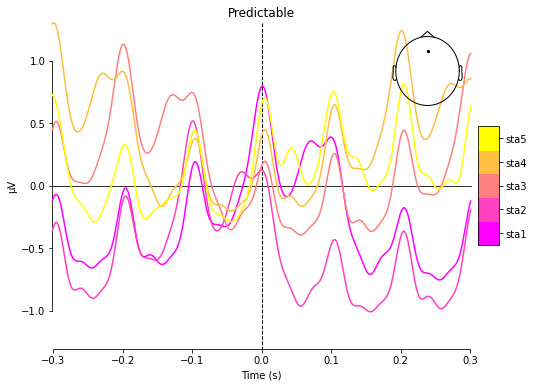

[<Figure size 576x432 with 3 Axes>]

In [9]:
mne.viz.plot_compare_evokeds(   {"sta1":evokeds_list_as_dict["predictable/1/standard"],
                                 "sta2":evokeds_list_as_dict["predictable/2/standard"],
                                 "sta3":evokeds_list_as_dict["predictable/3/standard"],
                                 "sta4":evokeds_list_as_dict["predictable/4/standard"],
                                 "sta5":evokeds_list_as_dict["predictable/5/standard"]}, picks="FZ", ci=False, cmap="spring", title="Predictable")

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import ptitprince as pt
import pandas as pd
import matplotlib.gridspec as gridspec
import scipy as sp
from copy import deepcopy

In [11]:
def get_mean_amplitudes(evokeds, window, picks = "all"):

    means = []
    if isinstance(evokeds, list):
        for i, evoked in enumerate(evokeds):
            evoked = evoked.copy().pick(picks)

            _window = np.arange(evoked.time_as_index(window[0]),
                                evoked.time_as_index(window[1]))

            data = evoked.data[:, _window]
            mean = data.mean()
            means.append(mean)
    else:
        return get_mean_amplitudes([evokeds], window, picks)[0]

    return means


def plot_conditions(data, cond1, cond2, pick="FZ", p_val = .05, peak = .140, title=None, axs=None, rerefernce = None,  topo_cmap="PiYG"):
    
    data = deepcopy(data)
    
    if axs is None:
        fig = plt.figure(constrained_layout=False, figsize = (9,3));
        fig.suptitle(title)
        ax, ax2 = fig.subplots(ncols=2, sharey = True);
    else:
        ax = axs[0]
        ax2 = axs[1]
        ax3 = axs[2]
        ax4 = axs[3]
        
        N1_avg = np.int(np.round(np.mean([e.nave for e in data[cond1]])))
        N2_avg = np.int(np.round(np.mean([e.nave for e in data[cond2]])))
        
        ax.set_title(title.format(N1="($N_{{{{avg}}}} = {}$)".format(N1_avg), 
                                  N2="($N_{{{{avg}}}} = {}$)").format(N2_avg))


    if rerefernce is not None:
        data[cond1] = [mne.set_eeg_reference(ev.copy(), rerefernce)[0] for ev in data[cond1]]
        data[cond2] = [mne.set_eeg_reference(ev.copy(), rerefernce)[0] for ev in data[cond2]]
        
    # Calculate diff waves
    org_diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(data[cond1], data[cond2])]
        
    # Combine Channels
    data[cond1] = [mne.channels.combine_channels(ev.copy(), {"mean": mne.pick_channels(ev.info["ch_names"], pick)}) for ev in data[cond1]]
    data[cond2] = [mne.channels.combine_channels(ev.copy(), {"mean": mne.pick_channels(ev.info["ch_names"], pick)}) for ev in data[cond2]]
    
    # Calculate diff waves
    diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(data[cond1], data[cond2])]

    condition1 = np.vstack(np.squeeze([ev.copy().pick("mean").data for ev in data[cond1]])) * 10e5
    condition2 = np.vstack(np.squeeze([ev.copy().pick("mean").data for ev in data[cond2]])) * 10e5
    

    T_obs, p_values, H0 =  mne.stats.permutation_t_test(condition1 - condition2, tail=0)
    

    mean_amplitudes_all = get_mean_amplitudes(diff_waves, peakwindow, picks = ["mean"]) 
    
    pdata_o = pd.DataFrame({"id":ids, "mean_amplitude": mean_amplitudes_all})
    pdata = pdata_o.melt(id_vars=['id'])
    pdata["value"] = pdata["value"]  * 10e5
    
    ax2.axhline(0, color="k");
    ax2 = pt.RainCloud(x="variable", y = "value", data = pdata, ax = ax2, bw = .4, width_viol=.3);
 
    
    times = data[cond1][0].times
    
    ax.axhline(0, color="k");
    ax.axvline(0, color="k");
    
    colors = ("#E99675", "#95A3C3", "#72B6A1")
    
    ax.plot(times, condition1.mean(axis=0), linestyle="dashed", color=colors[0], label=cond1);
    ax.plot(times, condition2.mean(axis=0), linestyle="dashed", color=colors[1], label=cond2);
    
    ax.plot(times, condition1.mean(axis=0)-condition2.mean(axis=0), color=colors[2], label="difference");
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("µV")
    ax.legend(loc="upper left")
    
    ttest = sp.stats.ttest_1samp(pdata_o["mean_amplitude"], 0)
    
    ax2.set_title("$p = {p:.4f}$".format(p=ttest[1]))
    ax2.set_ylabel("")
    ax2.set_xlabel("")
    
    ax.axvspan(peakwindow[0], peakwindow[1], color='k', alpha=0.1)

    ax.set_xlim(-.3,.3);
    
    last_p = 1
    span_start = 0
    
    
    for i, p in enumerate(p_values):
        
        #print("i = ", i, "p =", p, "t = ", times[i])
        
        if last_p >= p_val and p > p_val:
            span_start = i
            
        if last_p < p_val and p >= p_val:
            #if i - span_start > 0
            ax.axvspan(times[span_start], times[i], color='crimson', alpha=0.2)
        
        last_p = p
    else:
        if last_p < p_val:
            ax.axvspan(times[span_start], times[i], color='crimson', alpha=0.2)
    
    mne.grand_average(org_diff_waves).plot_topomap(peak, axes = axs[2:4], cmap=topo_cmap, average = 0.025)
    
    return fig if axs is None else axs

Permuting 9999 times...
Identifying common channels ...


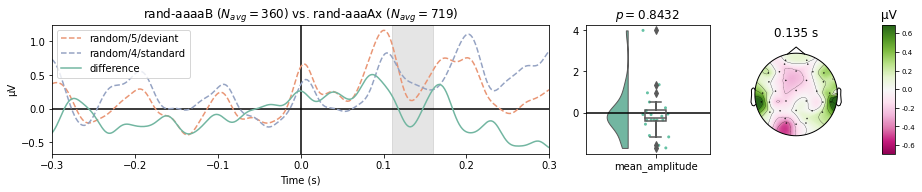

Permuting 9999 times...
Identifying common channels ...


<Figure size 432x288 with 0 Axes>

Permuting 9999 times...
Identifying common channels ...


<Figure size 432x288 with 0 Axes>

Permuting 9999 times...
Identifying common channels ...


<Figure size 432x288 with 0 Axes>

Permuting 9999 times...
Identifying common channels ...


<Figure size 432x288 with 0 Axes>

Permuting 9999 times...
Identifying common channels ...


<Figure size 432x288 with 0 Axes>

Permuting 9999 times...
Identifying common channels ...


<Figure size 432x288 with 0 Axes>

In [16]:
compare = { "rand-aaaaB {N1} vs. rand-aaaAx {N2}":("random/5/deviant", "random/4/standard"),
            "pred-aaaaB {N1} vs. pred-aaaAx {N2}":("predictable/5/deviant", "predictable/4/standard"),
            "pred-aaaaA {N1} vs. pred-aaaAx {N2}":("predictable/5/standard", "predictable/4/standard"),
            "rand-B {N1} vs. rand-A {N2}":("random/deviant", "random/standard"),
            #"pred-B {N1} vs. pred-A {N2}":("predictable/deviant", "predictable/standard"),
            "rand-aaaaB {N1} vs. rand-aaaaA {N2}":("random/5/deviant", "random/5/standard"),
            "pred-aaaaB {N1} vs. rand-aaaaA {N2}":("predictable/5/deviant", "random/5/standard"),
            "pred-aaaaA {N1} vs. rand-aaaaA {N2}":("predictable/5/standard", "random/5/standard")}

fig = plt.figure(tight_layout=True, figsize = (13, 2.7* len(compare)))
gs = gridspec.GridSpec(ncols=4, nrows=len(compare), width_ratios=[4,1,.8,.1], figure=fig, hspace=.5)

pick=["FZ", "CZ"]

for i, (l, c) in enumerate(compare.items()):
    axs = (fig.add_subplot(gs[i, 0]), fig.add_subplot(gs[i, 1]), fig.add_subplot(gs[i, 2]), fig.add_subplot(gs[i, 3]))
    #axs[0].get_shared_y_axes().join(axs[0], axs[1])
    plot_conditions(evokeds_list_as_dict, c[0], c[1], title=l, axs=axs, pick=pick, peak = peak_latency)
    
#fig.suptitle("ERPs for Channels {}".format(pick))
plt.show(fig)

Identifying common channels ...


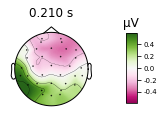

In [13]:
diff_waves = [mne.combine_evoked([e1,e2], [1,-1]) for e1,e2 in zip(evokeds_list_as_dict["predictable/5/standard"], evokeds_list_as_dict["predictable/4/standard"])]
    
avg = mne.grand_average(diff_waves).plot_topomap(0.21, cmap="PiYG")

In [14]:
 events = mne.find_events(raw, initial_event=True)

NameError: name 'raw' is not defined

In [ ]:
Nsamp = 100
S = 1000

